In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_11687/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_9536278,45.0,3.988203,1.0,1.0,ISIC_9536278.jpg
1,ISIC_7650956,65.0,3.988203,1.0,1.0,ISIC_7650956.jpg
2,ISIC_5730927,85.0,3.988203,0.0,1.0,ISIC_5730927.jpg
3,ISIC_4305055,85.0,3.988203,1.0,1.0,ISIC_4305055.jpg
4,ISIC_5681611,85.0,3.988203,1.0,1.0,ISIC_5681611.jpg


In [4]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [5]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


In [6]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))
sex_lookup = dict(zip(metadata['filename'], metadata['sex']))
age_lookup = dict(zip(metadata['filename'], metadata['age_approx']))
size_lookup = dict(zip(metadata['filename'], metadata['clin_size_long_diam_mm']))

# Lists for matched data
valid_image_paths = []
labels = []
sex_features = []
age_features = []
size_features = []

for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])
        sex_features.append(sex_lookup[fname])
        age_features.append(age_lookup[fname])
        size_features.append(size_lookup[fname])



In [7]:
trainval_paths, test_paths, trainval_labels, test_labels, \
trainval_sex, test_sex, trainval_age, test_age, trainval_size, test_size = sklearn.model_selection.train_test_split(
    valid_image_paths, labels, sex_features, age_features, size_features,
    test_size=0.1, random_state=42, shuffle=True
)


In [8]:
len(trainval_paths)

436973

In [9]:
from collections import defaultdict
import numpy as np
import shutil
import os

# Group filenames by class
label_to_paths = defaultdict(list)
for path, label in zip(trainval_paths, trainval_labels):
    label_to_paths[label].append(path)

# Sample train set (balanced)
train_paths, train_labels = [], []
for label in [0, 1]:
    paths = label_to_paths[label]
    np.random.seed(42)
    sampled_paths = np.random.choice(paths, 5000, replace=False)
    train_p = sampled_paths[:4000]
    train_paths.extend(train_p)
    train_labels.extend([label] * 4000)

# Sample val set (representative of real-world 96/4 split)
val_paths, val_labels = [], []

np.random.seed(42)
benign_val = np.random.choice(label_to_paths[0], 960, replace=False)
malignant_val = np.random.choice(label_to_paths[1], 40, replace=False)

val_paths.extend(benign_val)
val_labels.extend([0] * 960)
val_paths.extend(malignant_val)
val_labels.extend([1] * 40)


# Create new folders for train/val
for folder in ['images_train_balanced', 'images_val_balanced']:
    os.makedirs(folder, exist_ok=True)

# Copy files into balanced folders
for path in train_paths:
    shutil.copy(path, f'images_train_balanced/{os.path.basename(path)}')

for path in val_paths:
    shutil.copy(path, f'images_val_balanced/{os.path.basename(path)}')


In [10]:
'''
import os
import shutil
os.makedirs('./images_test', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test/{filename}')
'''

"\nimport os\nimport shutil\nos.makedirs('./images_test', exist_ok=True)\n\nfor path in test_paths:\n    filename = os.path.basename(path)\n    shutil.copy(path, f'./images_test/{filename}')\n"

In [11]:


train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_train_balanced',
    labels=train_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_val_balanced',
    labels=val_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test',
    labels=test_labels_sorted,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=False
)


Found 48553 files belonging to 2 classes.


In [13]:
# Ensure NumPy arrays are shaped (N, 3)
train_metadata_array = np.array(list(zip(trainval_sex[:len(train_paths)], 
                                         trainval_age[:len(train_paths)], 
                                         trainval_size[:len(train_paths)])), dtype=np.float32)
val_metadata_array = np.array(list(zip(trainval_sex[len(train_paths):], 
                                       trainval_age[len(train_paths):], 
                                       trainval_size[len(train_paths):])), dtype=np.float32)
test_metadata_array = np.array(list(zip(test_sex, test_age, test_size)), dtype=np.float32)

# Create image/label datasets (already batched)
train_images_only_ds = train_image_ds.map(lambda x, y: x)
train_labels_only_ds = train_image_ds.map(lambda x, y: y)

val_images_only_ds = val_image_ds.map(lambda x, y: x)
val_labels_only_ds = val_image_ds.map(lambda x, y: y)

test_images_only_ds = test_image_ds.map(lambda x, y: x)
test_labels_only_ds = test_image_ds.map(lambda x, y: y)

# Create metadata dataset and zip properly
train_metadata_ds = tf.data.Dataset.from_tensor_slices(train_metadata_array).batch(64,drop_remainder=True)
val_metadata_ds = tf.data.Dataset.from_tensor_slices(val_metadata_array).batch(64,drop_remainder=True)
test_metadata_ds = tf.data.Dataset.from_tensor_slices(test_metadata_array).batch(64,drop_remainder=True)

# Combine (image, metadata) as input
train_inputs_ds = tf.data.Dataset.zip((train_images_only_ds, train_metadata_ds))
val_inputs_ds = tf.data.Dataset.zip((val_images_only_ds, val_metadata_ds))
test_inputs_ds = tf.data.Dataset.zip((test_images_only_ds, test_metadata_ds))

# Final datasets
final_train_ds = tf.data.Dataset.zip((train_inputs_ds, train_labels_only_ds)).prefetch(tf.data.AUTOTUNE).repeat()
final_val_ds = tf.data.Dataset.zip((val_inputs_ds, val_labels_only_ds)).prefetch(tf.data.AUTOTUNE).repeat()
final_test_ds = tf.data.Dataset.zip((test_inputs_ds, test_labels_only_ds)).prefetch(tf.data.AUTOTUNE).repeat()



In [14]:
from tensorflow.keras.layers import Concatenate, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Image input branch
image_input = Input(shape=(128, 128, 3), name='image_input')
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)

# Metadata input branch (sex, age, size)
meta_input = Input(shape=(3,), name='meta_input')  # assuming 3 features
m = Dense(32, activation='relu')(meta_input)
m = Dense(16, activation='relu')(m)

# Combine image and metadata
combined = Concatenate()([x, m])
final_output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[image_input, meta_input], outputs=final_output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train top layers first
history = model.fit(final_train_ds,
          validation_data=final_val_ds,
          epochs=20,
          steps_per_epoch=125,
          validation_steps=15,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


# Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the whole model
history_finetune = model.fit(final_train_ds,
          validation_data=final_val_ds,
          epochs=50,
          steps_per_epoch=125,
          validation_steps=15,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])



Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5010 - loss: 0.7786 - val_accuracy: 0.1729 - val_loss: 0.7495
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.5070 - loss: 0.7040 - val_accuracy: 0.8573 - val_loss: 0.6330
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.5045 - loss: 0.6995 - val_accuracy: 0.1354 - val_loss: 0.7497
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.4891 - loss: 0.6979 - val_accuracy: 0.9510 - val_loss: 0.5437
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.5031 - loss: 0.7037 - val_accuracy: 0.9240 - val_loss: 0.6401
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.5002 - loss: 0.7002 - val_accuracy: 0.9302 - val_loss: 0.6146
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.4968 - loss: 0.6986 - val_accuracy: 0.4031 - val_loss: 0.6964
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.4928 - loss: 0

In [16]:
test_loss, test_accuracy = model.evaluate(final_test_ds,steps=759)

print(f"Test accuracy: {test_accuracy:.4f}")

759/759 ━━━━━━━━━━━━━━━━━━━━ 131s 171ms/step - accuracy: 0.7090 - loss: 0.6381
Test accuracy: 0.7315


In [17]:
y_pred_probs = model.predict(final_test_ds,steps=759)
y_pred = np.round(y_pred_probs).astype(int)

759/759 ━━━━━━━━━━━━━━━━━━━━ 130s 170ms/step


In [22]:
y_true = np.array(test_labels_sorted)
y_true = y_true[:len(y_pred)]

In [30]:
y_pred = y_pred[:len(y_true)]
y_pred_probs=y_pred_probs[:len(y_true)]

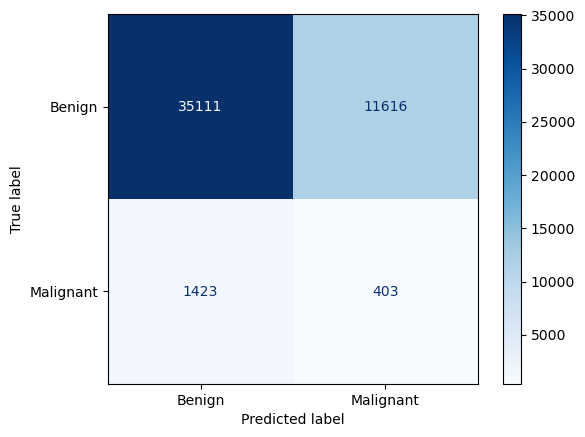

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues',values_format='d')


In [28]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.96      0.75      0.84     46727
   Malignant       0.03      0.22      0.06      1826

    accuracy                           0.73     48553
   macro avg       0.50      0.49      0.45     48553
weighted avg       0.93      0.73      0.81     48553



In [31]:
from sklearn.metrics import roc_auc_score


auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC: {auc:.4f}")


AUC: 0.4699


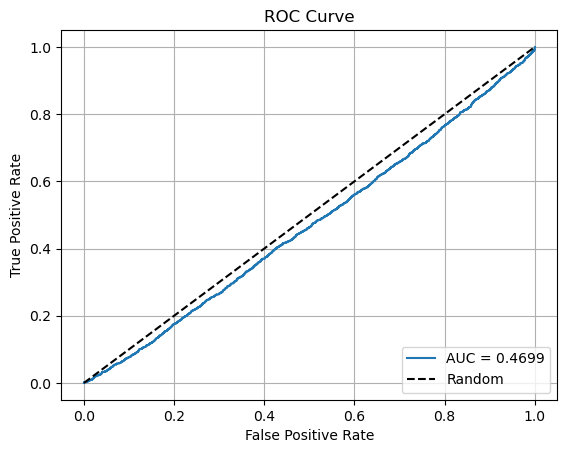

In [32]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get FPR (false positive rate), TPR (true positive rate), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [34]:
model.save('model_5000_meta.keras')